In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,53 mins 11 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,"21 days, 10 hours and 56 minutes"
H2O cluster name:,H2O_from_python_Davee_umjavj
H2O cluster total nodes:,1
H2O cluster free memory:,1.574 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [195]:
# Read data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [196]:
# Use H2O to create training and validation sets before data pre-processing
# Will now have three pandas data frames for test, training, and validation

h2otrain = h2o.H2OFrame(train)
h2otrain, h2ovalid = h2otrain.split_frame([0.7], seed=12345)
train = h2otrain.as_data_frame()
valid = h2ovalid.as_data_frame()

In [197]:
# Categorical Values

cat_train = train.select_dtypes(include=['object'])
cat_valid = valid.select_dtypes(include=['object'])
cat_test = test.select_dtypes(include=['object'])

In [198]:
# Numerical Values

num_train = train.select_dtypes(exclude=['object'])
num_valid = valid.select_dtypes(exclude=['object'])
num_test = test.select_dtypes(exclude=['object'])

## Data Pre-Processing

### Impute any NaN Values

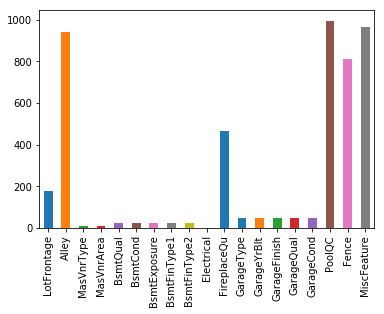

In [199]:
# Visualize Missing Values (both Numerical and Categorical)

trainmissing = train.isnull().sum()
trainmissing = trainmissing[trainmissing>0]

trainmissing
trainmissing.plot.bar()

In [200]:
# Numerical values I will impute NaN with the median (per professors code)
# Determine which columns have NaN

trcols = num_train.columns[num_train.isna().any()].tolist()
vacols = num_valid.columns[num_valid.isna().any()].tolist()
tecols = num_test.columns[num_test.isna().any()].tolist()

# Impute the median value for LotFrontage and GarageYrBlt

print('Training # Cols with NaN =', len(trcols))
print(trcols)
print()
print('Validation # Cols with NaN =', len(vacols))
print(vacols)
print()
print('Testing # Cols with NaN =', len(tecols))
print(tecols)

Training # Cols with NaN = 3
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

Validation # Cols with NaN = 3
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

Testing # Cols with NaN = 11
['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']


In [201]:
# Lot Frontage: Linear feet of street connected to property
out1 = num_train['LotFrontage'].isna().sum()

print('Total Missing Values of LotFrontage in Training =', out1)

Total Missing Values of LotFrontage in Training = 179


To impute the 179 missing values of LotFrontage, we can use the median of a related categorical factor. We looked at BldgType and MSZoning as we assumed both would relate to the linear feet of street connected to the property. Building type median seems to have the best correlation to LotFrontage and we will use it to impute our missing values

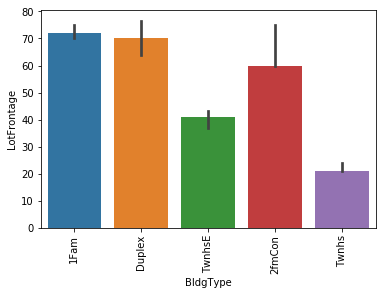

In [202]:
# This shows a bar plot of the median value per group with an error bar showing one standard deviation (to show variability)

sns.barplot(data=train,x='BldgType',y='LotFrontage', estimator=np.median)
plt.xticks(rotation=90)
plt.show()

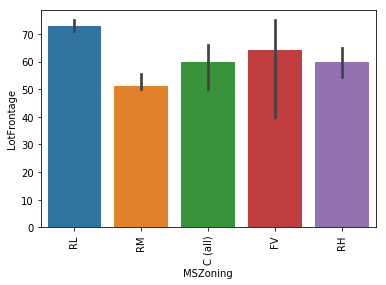

In [203]:
sns.barplot(data=train,x='MSZoning',y='LotFrontage', estimator=np.median)
plt.xticks(rotation=90)
plt.show()

In [204]:
# Assistance in creating this formula
# https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group

train['LotFrontage'] = train.groupby('BldgType')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Must also apply this to validation and testing data

valid['LotFrontage'] = valid.groupby('BldgType')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test['LotFrontage'] = test.groupby('BldgType')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [205]:
# MasVnrArea: Masonry veneer area in square feet

out2 = num_train['MasVnrArea'].isna().sum()

print('Total Missing Values of MasVnrArea in Training =', out2)

Total Missing Values of MasVnrArea in Training = 7


In [206]:
# These 7 missing values also have a missing veneer type

vnr = train[num_train['MasVnrArea'].isna()]
vnr['MasVnrType']

163    NaN
371    NaN
446    NaN
646    NaN
672    NaN
676    NaN
855    NaN
Name: MasVnrType, dtype: object

In [207]:
# We can simply replace all missing values here with 0
# Note, we also must do this for our validation and test data

train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
valid['MasVnrArea'] = valid['MasVnrArea'].fillna(0)
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

In [208]:
# GarageYrBlt: Year garage was built
out3 = num_train['GarageYrBlt'].isna().sum()

print('Total Missing Values of GarageYrBlt in Training =', out3)

garg = train[num_train['GarageYrBlt'].isna()]
garg['GarageType']

# Similar to before, these values all have a missing garage type meaning there is no garage and we can impute with 0

Total Missing Values of GarageYrBlt in Training = 48


28     NaN
35     NaN
55     NaN
63     NaN
64     NaN
89     NaN
98     NaN
103    NaN
108    NaN
113    NaN
115    NaN
149    NaN
166    NaN
202    NaN
269    NaN
274    NaN
309    NaN
346    NaN
370    NaN
392    NaN
408    NaN
430    NaN
439    NaN
440    NaN
508    NaN
518    NaN
567    NaN
578    NaN
636    NaN
659    NaN
669    NaN
675    NaN
700    NaN
720    NaN
762    NaN
782    NaN
807    NaN
840    NaN
841    NaN
848    NaN
867    NaN
884    NaN
909    NaN
911    NaN
919    NaN
963    NaN
994    NaN
997    NaN
Name: GarageType, dtype: object

In [209]:
# We can simply replace all missing values here with 0
# Note, we also must do this for our validation and test data

train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)
valid['GarageYrBlt'] = valid['GarageYrBlt'].fillna(0)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)

# We will do the same for Garage Cars and Garage Area that are missing in our test data set
# We cannot look at this data to determine if this is correct, but we must perform the actions based on our test data

train['GarageCars'] = train['GarageCars'].fillna(0)
valid['GarageCars'] = valid['GarageCars'].fillna(0)
test['GarageCars'] = test['GarageCars'].fillna(0)

train['GarageArea'] = train['GarageArea'].fillna(0)
valid['GarageArea'] = valid['GarageArea'].fillna(0)
test['GarageArea'] = test['GarageArea'].fillna(0)

In [210]:
# Finally, although there are no missing values in the test set for items related to the basement of a home
# our test data does have these issues. We will simply replace these missing values with zero assuming there is no
# basement at this location
# 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'

train['BsmtFinSF1'] = train['BsmtFinSF1'].fillna(0)
valid['BsmtFinSF1'] = valid['BsmtFinSF1'].fillna(0)
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(0)

train['BsmtFinSF2'] = train['BsmtFinSF2'].fillna(0)
valid['BsmtFinSF2'] = valid['BsmtFinSF2'].fillna(0)
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(0)

train['BsmtUnfSF'] = train['BsmtUnfSF'].fillna(0)
valid['BsmtUnfSF'] = valid['BsmtUnfSF'].fillna(0)
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(0)

train['TotalBsmtSF'] = train['TotalBsmtSF'].fillna(0)
valid['TotalBsmtSF'] = valid['TotalBsmtSF'].fillna(0)
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(0)

train['BsmtFullBath'] = train['BsmtFullBath'].fillna(0)
valid['BsmtFullBath'] = valid['BsmtFullBath'].fillna(0)
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(0)

train['BsmtHalfBath'] = train['BsmtHalfBath'].fillna(0)
valid['BsmtHalfBath'] = valid['BsmtHalfBath'].fillna(0)
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(0)

In [211]:
# Finally, we double check to make sure we have no more missing numerical values

num_train = train.select_dtypes(exclude=['object'])
num_valid = valid.select_dtypes(exclude=['object'])
num_test = test.select_dtypes(exclude=['object'])

trcols = num_train.columns[num_train.isna().any()].tolist()
vacols = num_valid.columns[num_valid.isna().any()].tolist()
tecols = num_test.columns[num_test.isna().any()].tolist()

print('Training # Cols with NaN =', len(trcols))
print(trcols)
print()
print('Validation # Cols with NaN =', len(vacols))
print(vacols)
print()
print('Testing # Cols with NaN =', len(tecols))
print(tecols)

Training # Cols with NaN = 0
[]

Validation # Cols with NaN = 0
[]

Testing # Cols with NaN = 0
[]


In [212]:
# Categorial values we will have to do case by case
# Start by determining which columns have NaN and what they should be replaced by
# For example: If no basement, all basement related will be NaN but they should say No Basement...

# Determine which columns have NaN

trcols = cat_train.columns[cat_train.isna().any()].tolist()
vacols = cat_valid.columns[cat_valid.isna().any()].tolist()
tecols = cat_test.columns[cat_test.isna().any()].tolist()

print('Training # Cols with NaN =', len(trcols))
print(trcols)
print()
print('Validation # Cols with NaN =', len(vacols))
print(vacols)
print()
print('Testing # Cols with NaN =', len(tecols))
print(tecols)

Training # Cols with NaN = 16
['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

Validation # Cols with NaN = 15
['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

Testing # Cols with NaN = 22
['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


In [213]:
# Alley: Type of alley access to property where NA equals No Alley

train['Alley'] = train['Alley'].fillna('NoAlley')
valid['Alley'] = valid['Alley'].fillna('NoAlley')
test['Alley'] = test['Alley'].fillna('NoAlley')

In [214]:
# MasVnrType: Masonry veneer type where we will assume NA equals None

train['MasVnrType'] = train['MasVnrType'].fillna('None')
valid['MasVnrType'] = valid['MasVnrType'].fillna('None')
test['MasVnrType'] = test['MasVnrType'].fillna('None')

Total Missing Values of Utilities in Training = 0


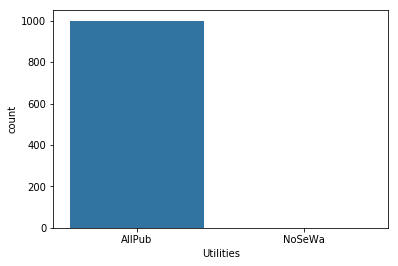

In [215]:
# Utilities: Type of utilities available
# There are no utility missing values in the training data, but we will replace this with all utilities available as
# all properties in the test set have all utilities available

out4 = cat_train['Utilities'].isna().sum()

print('Total Missing Values of Utilities in Training =', out4)

sns.countplot(x='Utilities', data=train)

In [216]:
train['Utilities'] = train['Utilities'].fillna('AllPub')
valid['Utilities'] = valid['Utilities'].fillna('AllPub')
test['Utilities'] = test['Utilities'].fillna('AllPub')

In [217]:
# Similar to our numerical data, we will assume all basement related missing values means there is no basement
# We confirm this below by looking at the numerical values about basements for those entries whose categorical basement values
# contains an NaN

out5 = cat_train['BsmtQual'].isna().sum()

print('Total Missing Values of Basement Quality in Training =', out5)

bsmt = train[cat_train['BsmtQual'].isna()]
bsmt['TotalBsmtSF']

Total Missing Values of Basement Quality in Training = 25


12     0
28     0
65     0
72     0
109    0
128    0
179    0
235    0
249    0
255    0
273    0
385    0
444    0
517    0
535    0
614    0
683    0
717    0
725    0
728    0
758    0
838    0
840    0
847    0
967    0
Name: TotalBsmtSF, dtype: int64

In [218]:
# NoBasement is confirmed and can be replaced in our set
# 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'

train['BsmtQual'] = train['BsmtQual'].fillna('NoBasement')
valid['BsmtQual'] = valid['BsmtQual'].fillna('NoBasement')
test['BsmtQual'] = test['BsmtQual'].fillna('NoBasement')

train['BsmtCond'] = train['BsmtCond'].fillna('NoBasement')
valid['BsmtCond'] = valid['BsmtCond'].fillna('NoBasement')
test['BsmtCond'] = test['BsmtCond'].fillna('NoBasement')

train['BsmtExposure'] = train['BsmtExposure'].fillna('NoBasement')
valid['BsmtExposure'] = valid['BsmtExposure'].fillna('NoBasement')
test['BsmtExposure'] = test['BsmtExposure'].fillna('NoBasement')

train['BsmtFinType1'] = train['BsmtFinType1'].fillna('NoBasement')
valid['BsmtFinType1'] = valid['BsmtFinType1'].fillna('NoBasement')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('NoBasement')

train['BsmtFinType2'] = train['BsmtFinType2'].fillna('NoBasement')
valid['BsmtFinType2'] = valid['BsmtFinType2'].fillna('NoBasement')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('NoBasement')

Total Missing Values of Electrical in Training = 1


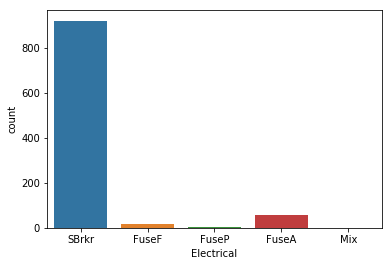

In [219]:
# Electrical: Electrical system

out6 = cat_train['Electrical'].isna().sum()

print('Total Missing Values of Electrical in Training =', out6)

elec = train[cat_train['Electrical'].isna()]
elec

sns.countplot(x='Electrical', data=train)

In [220]:
# There is only one missing electrical value in the test data.
# We will impute this and all others with a standard configuration as this is the most common configuration

train['Electrical'] = train['Electrical'].fillna('SBrkr')
valid['Electrical'] = valid['Electrical'].fillna('SBrkr')
test['Electrical'] = test['Electrical'].fillna('SBrkr')

Total Missing Values of FireplaceQu in Training = 466


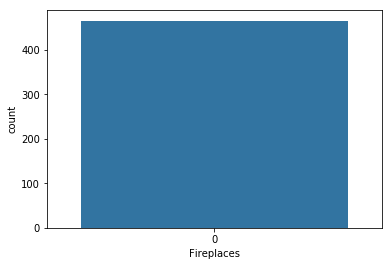

In [221]:
# 'FireplaceQu': Fireplace quality

out7 = cat_train['FireplaceQu'].isna().sum()

print('Total Missing Values of FireplaceQu in Training =', out7)

fire = train[cat_train['FireplaceQu'].isna()]

sns.countplot(x='Fireplaces', data=fire)

In [222]:
# As shown above, all missing fireplace quality values have 0 fireplaces

train['FireplaceQu'] = train['FireplaceQu'].fillna('NoFire')
valid['FireplaceQu'] = valid['FireplaceQu'].fillna('NoFire')
test['FireplaceQu'] = test['FireplaceQu'].fillna('NoFire')

Total Missing Values of PoolQC in Training = 995


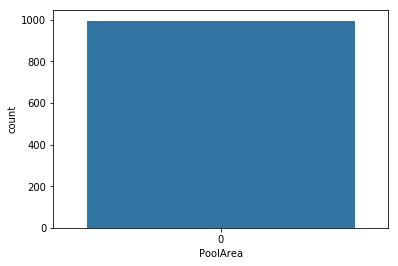

In [223]:
# 'PoolQC'

out8 = cat_train['PoolQC'].isna().sum()

print('Total Missing Values of PoolQC in Training =', out8)

pool = train[cat_train['PoolQC'].isna()]

sns.countplot(x='PoolArea', data=pool)

In [224]:
# As shown above, all missing pool quality values have 0 pools

train['PoolQC'] = train['PoolQC'].fillna('NoPool')
valid['PoolQC'] = valid['PoolQC'].fillna('NoPool')
test['PoolQC'] = test['PoolQC'].fillna('NoPool')

In [225]:
# 'Fence': Fence quality where NA equals no fence

train['Fence'] = train['Fence'].fillna('NoFence')
valid['Fence'] = valid['Fence'].fillna('NoFence')
test['Fence'] = test['Fence'].fillna('NoFence')

In [226]:
# 'MiscFeature': Miscellaneous feature not covered in other categories where NA equals None

train['MiscFeature'] = train['MiscFeature'].fillna('NoMisc')
valid['MiscFeature'] = valid['MiscFeature'].fillna('NoMisc')
test['MiscFeature'] = test['MiscFeature'].fillna('NoMisc')

In [227]:
# Similar to our numerical data, we will assume all garage related missing values means there is no garage
# We confirm this below by looking at the numerical values about garages for those entries whose categorical garage values
# contains an NaN

out9 = cat_train['GarageType'].isna().sum()

print('Total Missing Values of GarageType in Training =', out9)

gara = train[cat_train['GarageType'].isna()]
gara['GarageArea']

Total Missing Values of GarageType in Training = 48


28     0
35     0
55     0
63     0
64     0
89     0
98     0
103    0
108    0
113    0
115    0
149    0
166    0
202    0
269    0
274    0
309    0
346    0
370    0
392    0
408    0
430    0
439    0
440    0
508    0
518    0
567    0
578    0
636    0
659    0
669    0
675    0
700    0
720    0
762    0
782    0
807    0
840    0
841    0
848    0
867    0
884    0
909    0
911    0
919    0
963    0
994    0
997    0
Name: GarageArea, dtype: int64

In [228]:
# NoBasement is confirmed and can be replaced in our set
# 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'

train['GarageType'] = train['GarageType'].fillna('NoGarage')
valid['GarageType'] = valid['GarageType'].fillna('NoGarage')
test['GarageType'] = test['GarageType'].fillna('NoGarage')

train['GarageFinish'] = train['GarageFinish'].fillna('NoGarage')
valid['GarageFinish'] = valid['GarageFinish'].fillna('NoGarage')
test['GarageFinish'] = test['GarageFinish'].fillna('NoGarage')

train['GarageQual'] = train['GarageQual'].fillna('NoGarage')
valid['GarageQual'] = valid['GarageQual'].fillna('NoGarage')
test['GarageQual'] = test['GarageQual'].fillna('NoGarage')

train['GarageCond'] = train['GarageCond'].fillna('NoGarage')
valid['GarageCond'] = valid['GarageCond'].fillna('NoGarage')
test['GarageCond'] = test['GarageCond'].fillna('NoGarage')

In [229]:
# These features were not missing in the Training data but were missing in the Test Data
# 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType'

# 'MSZoning', Utilities', 'Functional', 'KitchenQual' will replace with most frequent value

train['MSZoning'] = train['MSZoning'].transform(lambda x: x.fillna(x.value_counts().index[0]))
valid['MSZoning'] = valid['MSZoning'].transform(lambda x: x.fillna(x.value_counts().index[0]))
test['MSZoning'] = test['MSZoning'].transform(lambda x: x.fillna(x.value_counts().index[0]))

train['Utilities'] = train['Utilities'].transform(lambda x: x.fillna(x.value_counts().index[0]))
valid['Utilities'] = valid['Utilities'].transform(lambda x: x.fillna(x.value_counts().index[0]))
test['Utilities'] = test['Utilities'].transform(lambda x: x.fillna(x.value_counts().index[0]))

train['Functional'] = train['Functional'].transform(lambda x: x.fillna(x.value_counts().index[0]))
valid['Functional'] = valid['Functional'].transform(lambda x: x.fillna(x.value_counts().index[0]))
test['Functional'] = test['Functional'].transform(lambda x: x.fillna(x.value_counts().index[0]))

train['KitchenQual'] = train['KitchenQual'].transform(lambda x: x.fillna(x.value_counts().index[0]))
valid['KitchenQual'] = valid['KitchenQual'].transform(lambda x: x.fillna(x.value_counts().index[0]))
test['KitchenQual'] = test['KitchenQual'].transform(lambda x: x.fillna(x.value_counts().index[0]))

# 'Exterior1st', 'Exterior2nd', 'SaleType' will replace with Other

train['Exterior1st'] = train['Exterior1st'].fillna('Other')
valid['Exterior1st'] = valid['Exterior1st'].fillna('Other')
test['Exterior1st'] = test['Exterior1st'].fillna('Other')

train['Exterior2nd'] = train['Exterior2nd'].fillna('Other')
valid['Exterior2nd'] = valid['Exterior2nd'].fillna('Other')
test['Exterior2nd'] = test['Exterior2nd'].fillna('Other')

train['SaleType'] = train['SaleType'].fillna('Other')
valid['SaleType'] = valid['SaleType'].fillna('Other')
test['SaleType'] = test['SaleType'].fillna('Other')

In [230]:
# Confirm I have removed all NaNs

trcols = train.columns[train.isna().any()].tolist()
vacols = valid.columns[valid.isna().any()].tolist()
tecols = test.columns[test.isna().any()].tolist()

print('Training # Cols with NaN =', len(trcols))
print(trcols)
print()
print('Validation # Cols with NaN =', len(vacols))
print(vacols)
print()
print('Testing # Cols with NaN =', len(tecols))
print(tecols)

Training # Cols with NaN = 0
[]

Validation # Cols with NaN = 0
[]

Testing # Cols with NaN = 0
[]


### Remove Outliers

In [231]:
num_train = train.select_dtypes(exclude=['object'])
trcols = num_train.columns.tolist()
trcols

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

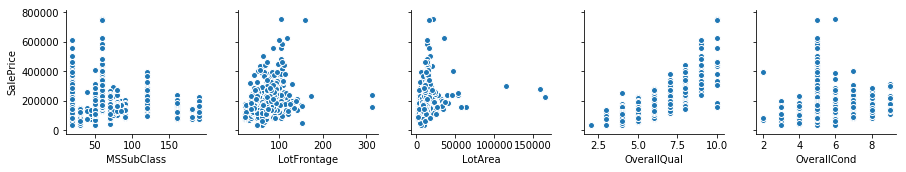

In [232]:
# Start by graphing all of the numerical values
# Remove outliers based on housing price

sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond'])

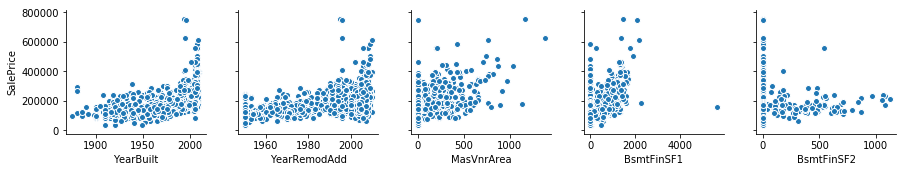

In [233]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2'])

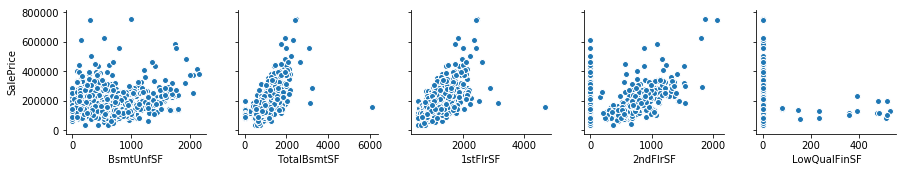

In [234]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF'])

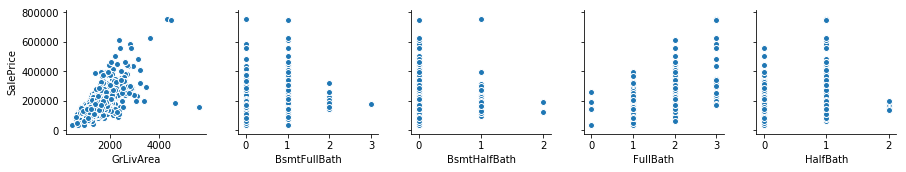

In [235]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'])

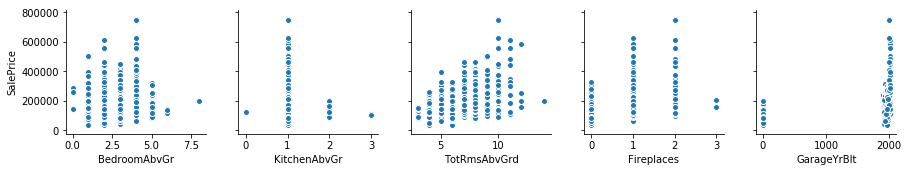

In [236]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt'])

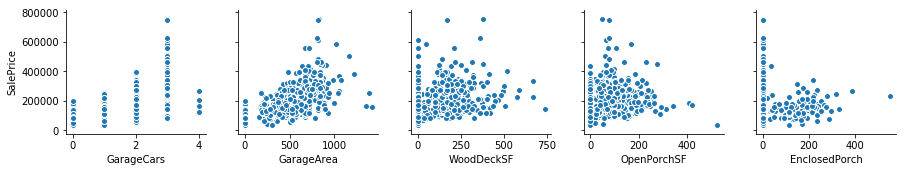

In [237]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch'])

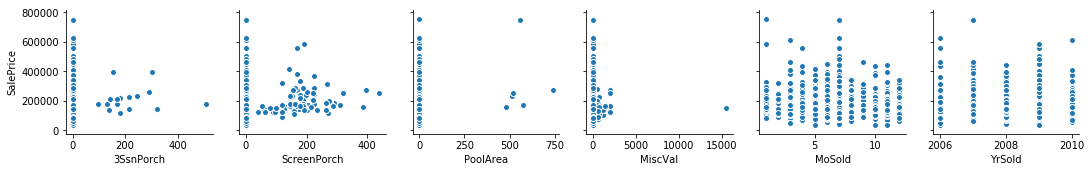

In [238]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'])

In [239]:
# Outliers are as follows (only removed from training data)
# LotFrontage > 300, LotArea > 100000, BsmtFinSF1 > 4000, TotalBsmtSF > 4000, 1stFlrSF > 4000
# GrLivArea > 4600, 3SsnPorch > 400, MiscVal > 10000

train = train.drop(train[(train['LotFrontage']>300) |
                         (train['LotArea']>100000) |
                         (train['BsmtFinSF1']>4000) |
                         (train['TotalBsmtSF']>4000) |
                         (train['1stFlrSF']>4000) |
                         (train['GrLivArea']>4600) |
                         (train['3SsnPorch']>400) |
                         (train['MiscVal']>10000)].index)

valid = valid.drop(valid[(valid['LotFrontage']>300) |
                         (valid['LotArea']>100000) |
                         (valid['BsmtFinSF1']>4000) |
                         (valid['TotalBsmtSF']>4000) |
                         (valid['1stFlrSF']>4000) |
                         (valid['GrLivArea']>4600) |
                         (valid['3SsnPorch']>400) |
                         (valid['MiscVal']>10000)].index)

## Issues with Training and Validation Set
After running model an initial time, a number of the test columns contained values not seen in the Test / Validation set. In order to fix this, we create a value 'Other' and impute those values with few entries.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

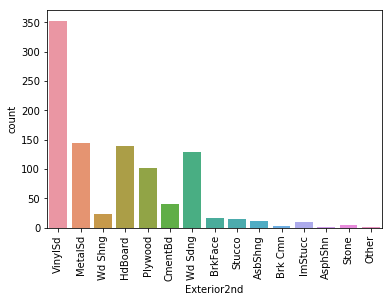

In [240]:
# Test/Validation dataset column 'Exterior2nd' has levels not trained on: [CBlock]

sns.countplot(x='Exterior2nd', data=train)
plt.xticks(rotation=90)

In [241]:
# Add value CBlock to Other in all three test sets

train['Exterior2nd'] = train['Exterior2nd'].replace('CBlock', 'Other')
valid['Exterior2nd'] = valid['Exterior2nd'].replace('CBlock', 'Other')
test['Exterior2nd'] = test['Exterior2nd'].replace('CBlock', 'Other')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

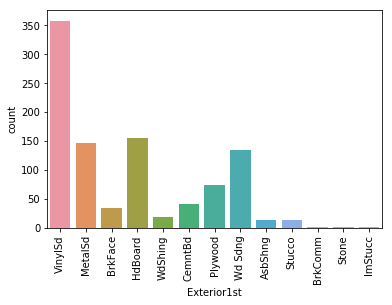

In [242]:
# Test/Validation dataset column 'Exterior1st' has levels not trained on: [AsphShn, CBlock]
# Test/Validation dataset column 'Exterior1st' has levels not trained on: [AsphShn, CBlock, Other]

sns.countplot(x='Exterior1st', data=train)
plt.xticks(rotation=90)

In [243]:
train['Exterior1st'] = train['Exterior1st'].replace(['AsphShn', 'CBlock','ImStucc'], 'Other')
valid['Exterior1st'] = valid['Exterior1st'].replace(['AsphShn', 'CBlock','ImStucc'], 'Other')
test['Exterior1st'] = test['Exterior1st'].replace(['AsphShn', 'CBlock','ImStucc'], 'Other')

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

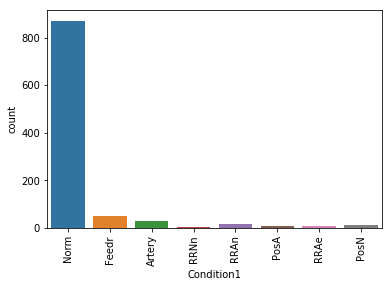

In [244]:
# Test/Validation dataset column 'Condition1' has levels not trained on: [RRNe]

sns.countplot(x='Condition1', data=train)
plt.xticks(rotation=90)

In [245]:
train['Condition1'] = train['Condition1'].replace(['RRNn','RRNe'], 'Other')
valid['Condition1'] = valid['Condition1'].replace(['RRNn','RRNe'], 'Other')
test['Condition1'] = test['Condition1'].replace(['RRNn','RRNe'], 'Other')

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

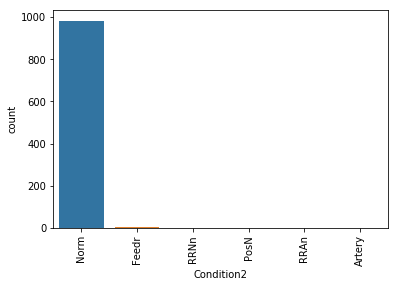

In [246]:
# Test/Validation dataset column 'Condition2' has levels not trained on: [PosA, RRAe]
# Test/Validation dataset column 'Condition2' has levels not trained on: [PosA]

sns.countplot(x='Condition2', data=train)
plt.xticks(rotation=90)

In [247]:
train['Condition2'] = train['Condition2'].replace(['PosA','RRAe','RRNn'], 'Other')
valid['Condition2'] = valid['Condition2'].replace(['PosA','RRAe','RRNn'], 'Other')
test['Condition2'] = test['Condition2'].replace(['PosA','RRAe','RRNn'], 'Other')

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

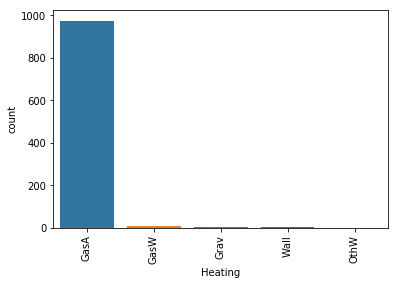

In [248]:
# Test/Validation dataset column 'Heating' has levels not trained on: [Floor]

sns.countplot(x='Heating', data=train)
plt.xticks(rotation=90)

In [249]:
train['Heating'] = train['Heating'].replace(['Floor'], 'OthW')
valid['Heating'] = valid['Heating'].replace(['Floor'], 'OthW')
test['Heating'] = test['Heating'].replace(['Floor'], 'OthW')

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

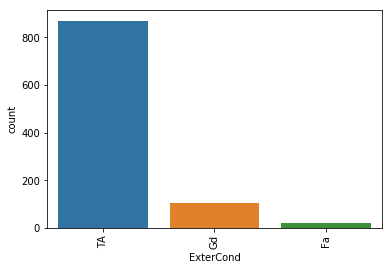

In [250]:
# Test/Validation dataset column 'ExterCond' has levels not trained on: [Ex, Po]

sns.countplot(x='ExterCond', data=train)
plt.xticks(rotation=90)

In [251]:
train['ExterCond'] = train['ExterCond'].replace(['Ex','Po','Fa'], 'Other')
valid['ExterCond'] = valid['ExterCond'].replace(['Ex','Po','Fa'], 'Other')
test['ExterCond'] = test['ExterCond'].replace(['Ex','Po','Fa'], 'Other')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

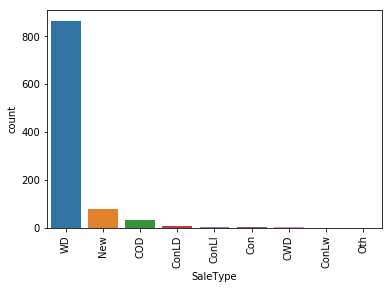

In [252]:
# Test/Validation dataset column 'SaleType' has levels not trained on: [Other]

sns.countplot(x='SaleType', data=train)
plt.xticks(rotation=90)

In [253]:
train['SaleType'] = train['SaleType'].replace('Other', 'Oth')
valid['SaleType'] = valid['SaleType'].replace('Other', 'Oth')
test['SaleType'] = test['SaleType'].replace('Other', 'Oth')

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

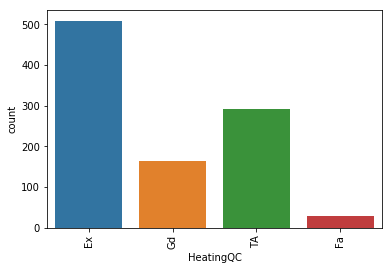

In [254]:
# Test/Validation dataset column 'HeatingQC' has levels not trained on: [Po]

sns.countplot(x='HeatingQC', data=train)
plt.xticks(rotation=90)

In [255]:
train['HeatingQC'] = train['HeatingQC'].replace(['Po','Fa'], 'Other')
valid['HeatingQC'] = valid['HeatingQC'].replace(['Po','Fa'], 'Other')
test['HeatingQC'] = test['HeatingQC'].replace(['Po','Fa'], 'Other')

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

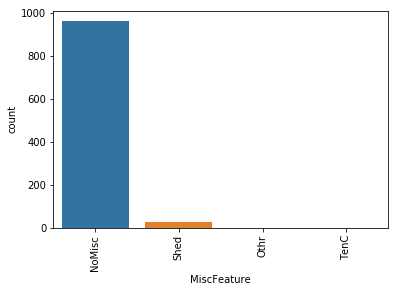

In [256]:
# Test/Validation dataset column 'MiscFeature' has levels not trained on: [Gar2]

sns.countplot(x='MiscFeature', data=train)
plt.xticks(rotation=90)

In [257]:
train['MiscFeature'] = train['MiscFeature'].replace('Gar2', 'Othr')
valid['MiscFeature'] = valid['MiscFeature'].replace('Gar2', 'Othr')
test['MiscFeature'] = test['MiscFeature'].replace('Gar2', 'Othr')

### Normalize home prices (log transform per notes)

C:\Users\Davee\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


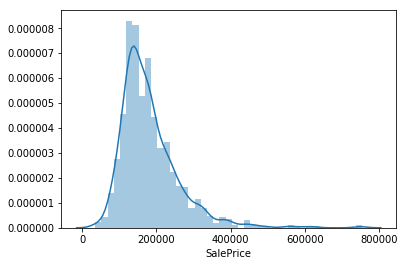

In [258]:
sns.distplot(train['SalePrice'])

In [259]:
# Apply log transform
train["SalePrice"] = train["SalePrice"].apply(np.log)
valid["SalePrice"] = valid["SalePrice"].apply(np.log)

C:\Users\Davee\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


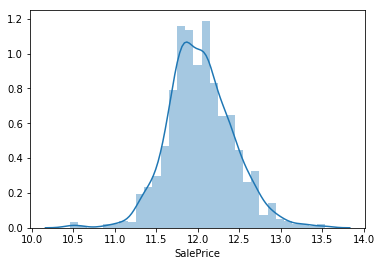

In [260]:
# Normalized data
sns.distplot(train['SalePrice'])

### One-Hot Encoding of Categorical Variables

In [261]:
# Need to re-initialize my categorical dataframes with updated / imputed information

cat_train = train.select_dtypes(include=['object'])
cat_valid = valid.select_dtypes(include=['object'])
cat_test = test.select_dtypes(include=['object'])

In [262]:
# Taken directly from professor's code

# one-hot encode training frame
train_cats_df = cat_train
train_cats_df_dummies = pd.get_dummies(train_cats_df)

# one-hot encode validation frame
valid_cats_df = cat_valid
valid_cats_df_dummies = pd.get_dummies(valid_cats_df)

# keep only the same new columns in the encoded new frames
# (they different b/c of different levels in variables)
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(valid_cats_df_dummies.columns))
valid_diff_cols = list(set(valid_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
valid_cats_df_dummies.drop(valid_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in both frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# one-hot encode test frame
test_cats_df = cat_test
test_cats_df_dummies = pd.get_dummies(test_cats_df)

# keep only the same new columns in train and valid encoded frames
# (they different b/c of different levels in variables)
# remove columns in train and valid encoded frames not in encoded test frame
# remember encoded train and valid now have same columns
# so only need to check for train OR valid, not both
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(test_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
valid_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in encoded train and valid frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# now remove columns in encoded test not in encoded train and valid
# (they different b/c of different levels in variables)
train_diff_cols = list(set(test_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
test_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in all encoded frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(test_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns) and all(valid_cats_df_dummies.columns == test_cats_df_dummies.columns))

(993, 232)
(457, 232)
True
(993, 228)
(457, 228)
True
(993, 228)
(457, 228)
(1459, 228)
True


In [263]:
# convert to h2o
train_one_hot = h2o.H2OFrame(train_cats_df_dummies.as_matrix())
train_one_hot.columns = list(train_cats_df_dummies.columns)
train = h2o.H2OFrame(train)
train = train.cbind(train_one_hot)

valid_one_hot = h2o.H2OFrame(valid_cats_df_dummies.as_matrix())
valid_one_hot.columns = list(valid_cats_df_dummies.columns)
valid = h2o.H2OFrame(valid)
valid = valid.cbind(valid_one_hot)

test_one_hot = h2o.H2OFrame(test_cats_df_dummies.as_matrix())
test_one_hot.columns = list(test_cats_df_dummies.columns)
test = h2o.H2OFrame(test)
test = test.cbind(test_one_hot)

In [264]:
# corrmat = train.corr()
# f, ax = plt.subplots(figsize=(50, 15))
# sns.heatmap(corrmat, vmax=0.8, square=True,center=0)

In [265]:
# Encoding Categorical Variables: http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.pdf

# This is an option to try later on

In [266]:
# Can also try the combined features from professor's code

## Perform Analysis

### Define Model with Grid Search (per professor's code)

In [267]:
def  glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best

### Also define function to generate submission file (per professor's code)

In [268]:
import re
import time

def gen_submission(model, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param model: Model with which to score test data.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(model.predict(test).exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = 'C:/Users/Davee/Google Drive/GWU MBA/Summer 2018/Machine Learning/submission_' + str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)

In [269]:
h2o.show_progress()

In [270]:
colselect = h2otrain.as_data_frame()
glm_cols = colselect.columns.tolist()

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                     model_ids  \
0    [0.99]  Grid_GLM_py_40_sid_8696_model_python_1529016315866_3_model_3   
1     [0.5]  Grid_GLM_py_40_sid_8696_model_python_1529016315866_3_model_2   
2    [0.25]  Grid_GLM_py_40_sid_8696_model_python_1529016315866_3_model_1   
3    [0.01]  Grid_GLM_py_40_sid_8696_model_python_1529016315866_3_model_0   

    residual_deviance  
0   5.647610823784473  
1   5.653570862953342  
2  5.6616679538842805  
3   6.340608130327399  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_40_sid_8696_model_python_1529016315866_3_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.01400297496268644
RMSE: 0.11833416650607059
MAE: 0.08291491388518299
RMSLE: 0.009258676610625415
R^2: 0.9099269895438749
Mean Residual Deviance: 0.01400297496268644
Null degrees of freedom:

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2018-06-14 19:38:53,0.000 sec,1,.32E0,1,0.1554625,0.1684591
,2018-06-14 19:38:53,0.002 sec,2,.31E0,2,0.1463011,0.1579085
,2018-06-14 19:38:53,0.005 sec,3,.3E0,2,0.1379501,0.1482940
,2018-06-14 19:38:53,0.008 sec,4,.28E0,2,0.1303377,0.1395330
,2018-06-14 19:38:53,0.012 sec,5,.27E0,2,0.1233989,0.1315500
---,---,---,---,---,---,---,---
,2018-06-14 19:38:53,0.429 sec,96,.39E-2,37,0.0146281,0.0126436
,2018-06-14 19:38:53,0.438 sec,97,.37E-2,38,0.0144666,0.0125669
,2018-06-14 19:38:53,0.446 sec,98,.36E-2,40,0.0143085,0.0124932
,2018-06-14 19:38:53,0.452 sec,99,.34E-2,42,0.0141442,0.0124238



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,11.951
12.2061,12.3702
11.6784,11.676
11.7906,11.8047
11.9117,11.9733
11.9767,11.956
11.8451,11.7863
11.1346,11.2219
11.914,11.7873
11.8845,11.918



glm prediction progress: |████████████████████████████████████████████████| 100%


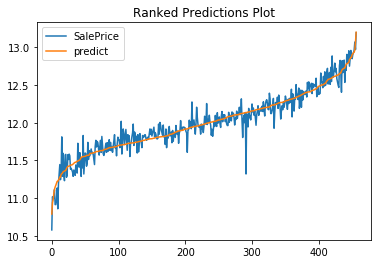

In [271]:
glm_0 = glm_grid(glm_cols, 'SalePrice', train, valid)
gen_submission(glm_0)

In [272]:
# Initial score of 0.12759
# After fixing warnings/errors, score of 0.12759 (did not change)

In [273]:
# Try XGBoost on this data set through H2O
# H2O GBM
# See XGBoost Notebook
# Install keras

